In [1]:
# Importamos paquetes y cosas importantes:

from ORM_database import Quarantine, Comuna, TimeSerie
import matplotlib.pyplot as plt
import pandas as pd

Definimos algunas funciones que realizan las consultas y serán útiles más adelante: 

In [2]:
def get_contagiados(id_comuna):
    '''
    Obtiene un dataframe con los contagiados totales por  comuna,
    consultando la base de datos previamente construida
    :param id_comuna: entero con el id de la comuna
    :return: dataframe
    '''
    query = (TimeSerie.
             select(TimeSerie.date, TimeSerie.value).
             where((TimeSerie.comuna_id == id_comuna) & (TimeSerie.serie_id == 0)))
    df = pd.DataFrame(list(query.dicts()))
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df


def get_cuarentenas(id_comuna):
    """
    Obtiene un dataframe con las cuarentenas aplicadas a cada comuna,
    consultando la base de datos previamente construida
    :param id_comuna: entero con el id de la comuna
    :return: dataframe
    """
    query = (Quarantine.
             select(Quarantine.init_day, Quarantine.end_day).
             where((Quarantine.comuna_id == id_comuna)))
    df = pd.DataFrame(list(query.dicts()))
    df['init_day'] = pd.to_datetime(df['init_day'])
    df['end_day'] = pd.to_datetime(df['end_day'])
    return df


def get_movilidad(id_comuna):
    """
    Obtiene un dataframe con los índices de movilidad de cada comuna,
    consultando la base de datos previamente construida
    :param id_comuna: entero con el id de la comuna
    :return: dataframe
    """
    query = (TimeSerie.
             select(TimeSerie.date, TimeSerie.value).
             where((TimeSerie.comuna_id == id_comuna) & (TimeSerie.serie_id == 1)))
    df = pd.DataFrame(list(query.dicts()))
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

def get_sintomas(id_comuna):
    """
    Obtiene un dataframe con casos de contagiados nuevos por fecha de inicio de síntomas por comuna, por semana epidemiológica
    consultando la base de datos previamente construida
    :param id_comuna: entero con el id de la comuna
    :return: dataframe
    """
    query = (TimeSerie.
             select(TimeSerie.date, TimeSerie.value).
             where((TimeSerie.comuna_id == id_comuna) & (TimeSerie.serie_id == 2)))
    df = pd.DataFrame(list(query.dicts()))
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df


def get_all(id_comuna):
    """
    Ejecuta todas las funciones anteriores
    :param id_comuna: entero con el id de cada comuna
    :return: cuatro dataframes con la información pedida
    """
    c = get_contagiados(id_comuna)
    q = get_cuarentenas(id_comuna)
    m = get_movilidad(id_comuna)
    s = get_sintomas(id_comuna)
    return c, q, m, s

Definimos las funciones para realizar los gráficos de interés:

In [3]:
def plot_contagiadosVSmov():
    """
    Realiza un gráfico triple con los contagiados totales, el porcentaje de crecimiento de contagiados y
    e índice de movilidad para todas las comunas que se encuentren en la base de datos.
    :return: realiza un gráfico
    """
    fig, ax = plt.subplots(3)
    fig.tight_layout(pad=3.0)
    query = (TimeSerie.
             select(TimeSerie.date, TimeSerie.value, TimeSerie.comuna_id, Comuna.comuna_name).
             join(Comuna, on=(TimeSerie.comuna_id == Comuna.comuna_id)).
             where(TimeSerie.serie_id == 0))
    df_c = pd.DataFrame(list(query.dicts()))
    df_c.set_index('date', inplace=True)
    df_c.groupby('comuna_name')['value'].plot(ax=ax[0], legend=True, linewidth=1)

    df_c['pct_change'] = df_c['value'].pct_change()
    df_c.groupby('comuna_name')['pct_change'].plot(ax=ax[1], legend=True, linewidth=1)

    query = (TimeSerie.
             select(TimeSerie.date, TimeSerie.value, TimeSerie.comuna_id, Comuna.comuna_name).
             join(Comuna, on=(TimeSerie.comuna_id == Comuna.comuna_id)).
             where(TimeSerie.serie_id == 1))
    df_m = pd.DataFrame(list(query.dicts()))
    df_m.set_index('date', inplace=True)
    df_m.groupby('comuna_name')['value'].plot(ax=ax[2], legend=True, linewidth=1)

    ax[0].set_xlim(min(min(df_m.index), min(df_c.index)), max(max(df_c.index), max(df_m.index)))
    ax[1].set_xlim(min(min(df_m.index), min(df_c.index)), max(max(df_c.index), max(df_m.index)))
    ax[2].set_xlim(min(min(df_m.index), min(df_c.index)), max(max(df_c.index), max(df_m.index)))
    ax[0].set_ylabel("Contagiados Totales")
    ax[1].set_ylabel("Cambio Porcentual\n Contagiados")
    ax[2].set_ylabel("Indice de Movilidad")
    ax[0].set_xlabel("Fecha")
    ax[1].set_xlabel("Fecha")
    ax[0].legend(prop={'size': 10})
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    plt.show()

def quarantine_analisis(df_c, df_q, df_m, df_s, name):
    """
    Utiliza los dataframes de contagiados, cuarentena, movilidad y casos nuevos por inicio de síntomas para una sóla comuna
    y realiza graficos comparativos en base a estos datos. 
    :param df_c: dataframe de contagiados de la comuna
    :param df_q: dataframe de cuarentenas de la comuna
    :param df_m: dataframe de indice de movilidad de la comuna
    :param df_s: dataframe de casos nuevos pro inicio de síntomas de la comuna
    :param name: nombre de la comuna que se está analizando
    :return: realiza un gráfico.
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
    fig.suptitle("Análisis Cuarentena " + name)
    fig.tight_layout(pad=4)
    df_r = df_c.pct_change()

    df_c['value'].plot(linewidth=1, label=name, ax=ax1)
    df_r['value'].plot(linewidth=1, label=name, ax=ax2)
    df_m['value'].plot(linewidth=1, label=name, ax=ax3)
    df_s['value'].plot(linewidth=1, marker='o', label=name, ax=ax4)

    for quarantine in df_q['init_day']:
        ax1.axvline(quarantine, color='lightcoral', linestyle='-', linewidth=3, label='Inicio Cuarentena')
        ax2.axvline(quarantine, color='lightcoral', linestyle='-', linewidth=3)
        ax3.axvline(quarantine, color='lightcoral', linestyle='-', linewidth=3)
        ax4.axvline(quarantine, color='lightcoral', linestyle='-', linewidth=3)

    for quarantine in df_q['end_day']:
        ax1.axvline(quarantine, color='forestgreen', linestyle='--', linewidth=2, label='Fin Cuarentena')
        ax2.axvline(quarantine, color='forestgreen', linestyle='--', linewidth=2)
        ax3.axvline(quarantine, color='forestgreen', linestyle='--', linewidth=2)
        ax4.axvline(quarantine, color='forestgreen', linestyle='--', linewidth=2)

    # Seteamos parámetros para que el gráfico sea más bonito :P 
    ax1.set_xlim(min(min(df_c.index), min(df_m.index), min(df_s.index)),
                 max(max(df_c.index), max(df_m.index), max(df_s.index)))

    ax1.tick_params(labelbottom=False)
    ax1.set_xlabel('')
    ax1.grid()
    ax2.set_xlim(min(min(df_c.index), min(df_m.index), min(df_s.index)),
                 max(max(df_c.index), max(df_m.index), max(df_s.index)))
    ax2.tick_params(labelbottom=False)
    ax2.set_xlabel('')
    ax2.grid()
    ax3.set_xlim(min(min(df_c.index), min(df_m.index), min(df_s.index)),
                 max(max(df_c.index), max(df_m.index), max(df_s.index)))
    ax3.set_xlabel('')
    ax3.grid()
    ax4.set_xlim(min(min(df_c.index), min(df_m.index), min(df_s.index)),
                 max(max(df_c.index), max(df_m.index), max(df_s.index)))
    ax4.grid()
    ax4.set_xlabel('Fecha')
    ax1.set_ylabel("Contagiados \nTotales")
    ax2.set_ylabel("Cambio Porcentual\n Contagiados")
    ax3.set_ylabel("Indice de\n Movilidad")
    ax4.set_ylabel("Casos Nuevos por\n fecha de inicio síntomas")
    plt.show()


    En primer lugar, mostramos una perspectiva general de la pandemia para algunas comunas. Por simplicidad sólo se escogieron 6: Las Condes, Providencia, Stgo Centro, Pte Alto, La Florida y Quilicura, sin embargo, modificando adecuadamente el archivo que guarda los datos en la base de datos se podría realizar este mismo análisis para otras comunas. Se decidieron escoger las primeras 3 por ser la primera generación de comunas a las cuales se les aplicaron Cuarentenas parciales. Por el otro lado, Pte Alto, La Florida y Quilicura fueron comunas que no tuvieron sus primeras cuarentenas sino hasta mucho después.

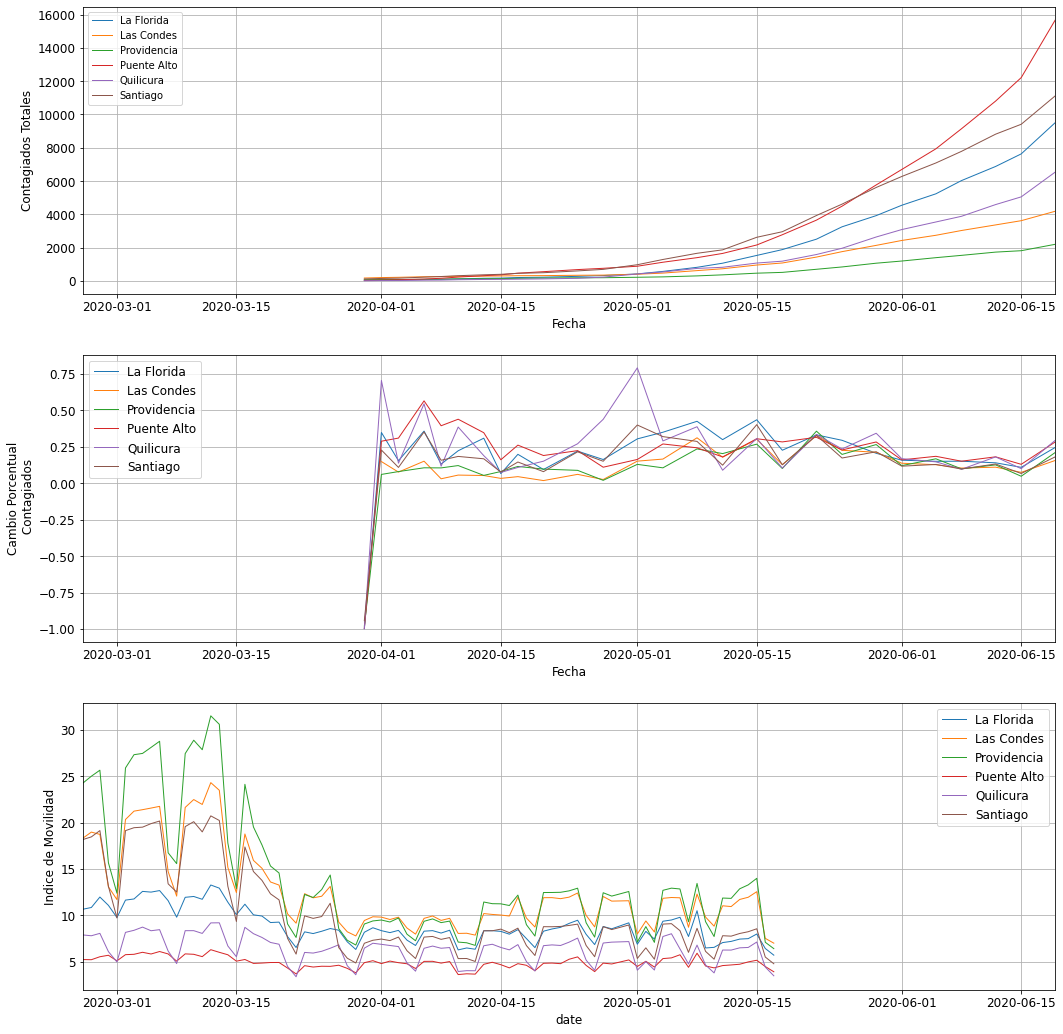

In [4]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 12})
plot_contagiadosVSmov()


##### Nota: Como se puede ver, ninguna de las 3 series de tiempo tiene datos completos :(

    De lo anterior se puede apreciar que la movilidad disminuyó notablemente alrededor de la quincena de Marzo, que fue justamente cuando decidieron empezar a cerrar colegios y algunas universidades, ya que Chile había entrado en una etapa más avanzada de la pandemia. Llama la atención que las movilidad de Puente Alto se ha mantenido más o menos constante desde principios de Marzo hasta la quincena de Mayo (que es hasta donde llegan los datos). 

    Por otro lado, llama la atención que si bien Providencia se mantiene con niveles relativamente altos de movilidad con respecto a las demás comunas, también mantiene el menor número de contagiados totales. Y es aún más notable el hecho de que Puente Alto presenta un comportamiento inverso: Tiene niveles más bajos de movilidad con respecto a las otras comunas, y sin embargo presenta un número alto de contagiados. 


    A continuación pasaremos a analizar algunas de estas comunas para analizar si las cuarentenas fueron efectivas bajo dos parámetros:
    1. Disminución de la movilidad (Midiendo la efectividad de la medida restrictiva en si, y si efectivamente sirvió para restringir la movilidad).
    2. Disminución efectiva del cambio porcentual de contagiados (Midiendo la efectividad de la medida "cuarentena" sobre la pandemia)
    
    
    
    Comenzamos analizando Las Condes, que fue una de las primeras comunas en las que se puso cuarentena parcial. En Rojo se muestra el inicio de una cuarentena y en la linea punteada verde el final de esta:

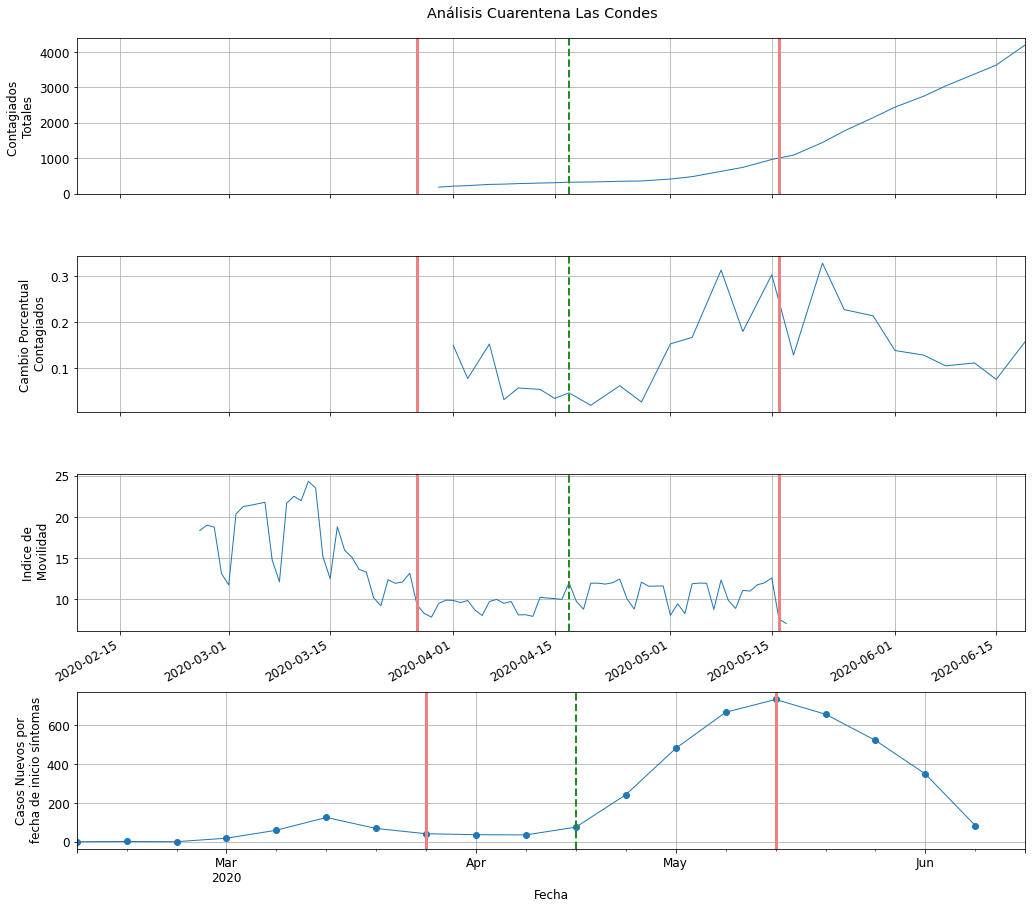

Cuarentenas Las Condes:


,init_day,end_day
0,2020-03-27,2020-04-17
1,2020-05-16,2020-06-27


In [5]:
c_LC, q_LC, m_LC, s_LC = get_all(13114)
quarantine_analisis(c_LC, q_LC, m_LC, s_LC, "Las Condes")
print("Cuarentenas Las Condes:")
q_LC

#### Nota: Los Casos Nuevos por fecha de Inicio de síntomas se agrupan por "Semana Epidemiológica" por lo que no se tienen datos para cada día sino el acumulado por semana, por eso se muestran puntos sobre la línea, que representan el valor al inicio de la semana epidemiológica. 

    En primer lugar, notamos que, una vez que se decretó la primera cuarentena en esta comuna (27 de Marzo), efectivamente la movilidad de la gente disminuyó y se mantuvo baja hasta el momento en que esta se levanta el día 17 de Abril, desde donde se aprecia un leve aumento de la movilidad. 
    Por otro lado, después de decretada esta cuarentena también se puede observar que disminuyó el aumento porcentual de la cantidad de contagiados totales. Lamentablemtente, luego de que esta primera cuarentena se levanta comienza a apreciarse un aumento en el porcentaje de casos por día, lo cual también se nota del gráfico de Casos nuevos por fecha de inicio de síntomas.
    
    Ahora observaremos Providencia, una de las comunas que también fue de las primeras en entrar a cuarentena y en el primer gráfico presentaba una movilidad relativamente alta, y pocos contagiados:
    
    

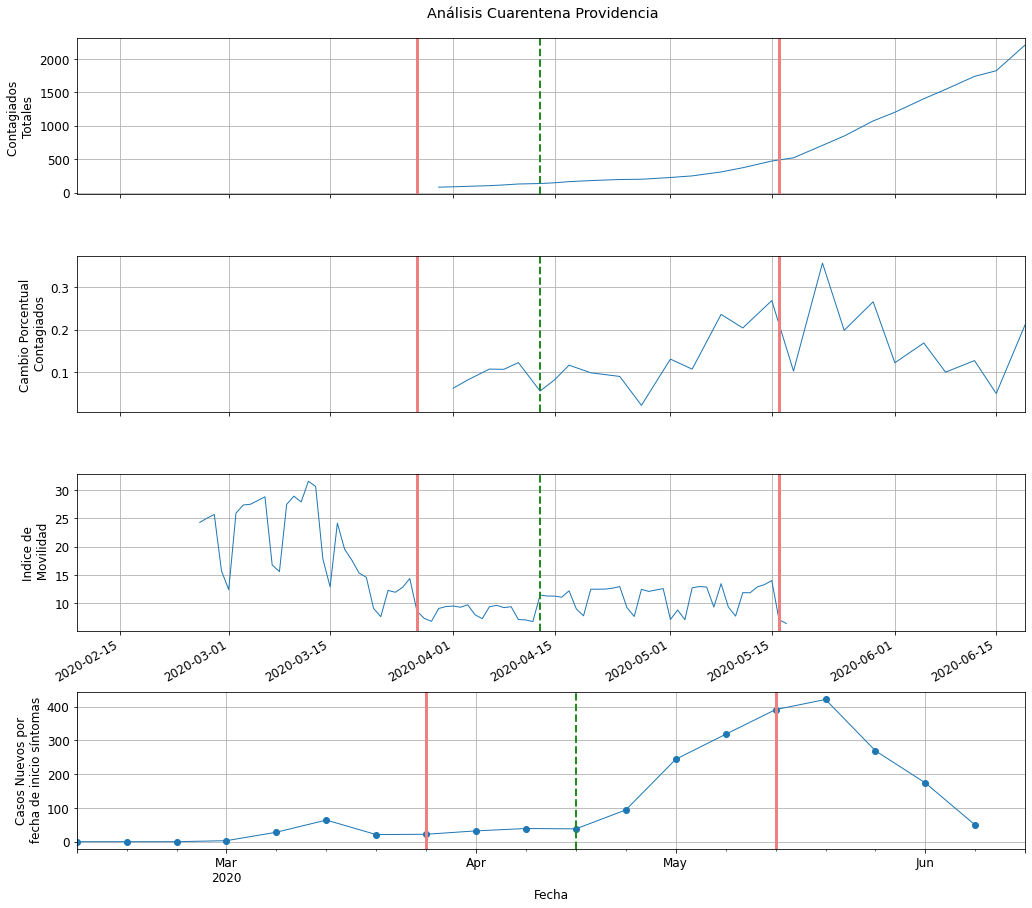

Cuarentenas Providencia:


,init_day,end_day
0,2020-03-27,2020-04-13
1,2020-05-16,2020-06-27


In [6]:
c_PR, q_PR, m_PR, s_PR = get_all(13123)
quarantine_analisis(c_PR, q_PR, m_PR, s_PR, "Providencia")
print("Cuarentenas Providencia:")
q_PR

    Como se puede ver, esta presenta las mismas cuarenetnnas que Las Condes, y un comportamiento muy parecido en cuanto a la movilidad (La cual disminuye en aproximadamente 15 puntos con respecto a su nivel más alto luego de decretada la primera cuarentena), y en cuanto a número de contagiados (Los cuales bajan luego de decretada la cuarentena y vuelven a aumentar una vez que esta se levanta).
    
    Analizaremos ahora a Puente Alto, la cual presentaba poca variación en su nivel de movilidad en el gráfico general, además de un gran número de contagiados a la fecha:

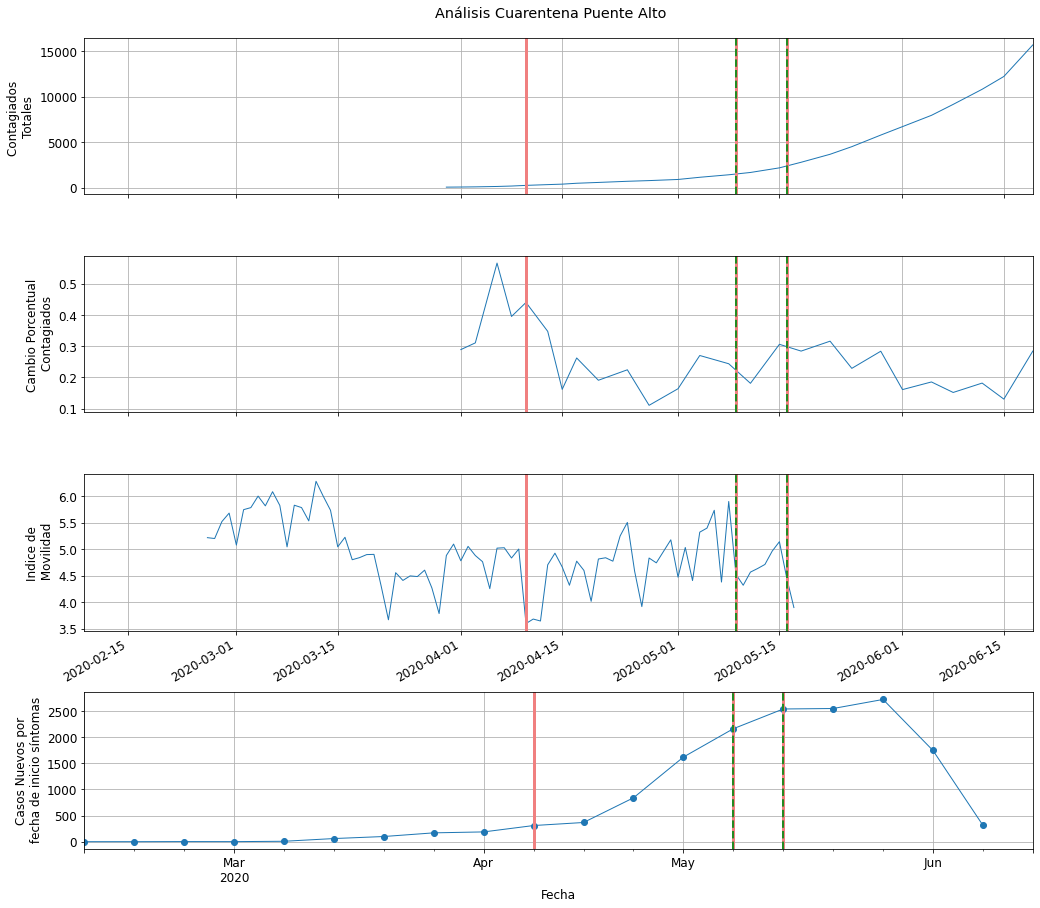

Cuarentenas Puente Alto:


,init_day,end_day
0,2020-04-10,2020-05-09
1,2020-05-09,2020-05-16
2,2020-05-16,2020-06-27


In [7]:
c_PA, q_PA, m_PA, s_PA = get_all(13201)
quarantine_analisis(c_PA, q_PA, m_PA, s_PA, "Puente Alto")
print("Cuarentenas Puente Alto:")
q_PA

    En primer lugar, notamos que hubieron dos extensiones de cuarentena para esta comuna (representadas por la línea verde punteada sobre la línea roja). 
    Esta comuna, al igual que las demás, también presenta una disminución de su índice de movilidad a partir de la quincena de Marzo, sin embargo, esta disminución fue de apenas un punto. Además, posterior a que se decreta cuarentena para esta comuna el 10 de Abril podemos ver que la disminución promedio del indice de movilidad tampoco resulta ser muy grande con respecto a las semanas anteriores, y este índice se sigue manteniendo entre 4.5 y 6.
    Sin embargo, en lo que respecta al cambio porcentual del número de contagiados de la comuna, podemos notar que este si se mantiene por debajo del peak que se logró antes de decretar la cuarentena. Llama la atención que el número de casos nuevos por inicio de síntomas logra un peak hacia finales de Mayo, pero luego de decretada la tercera cuarentena de la comuna se puede observar que este número disminuye. 
    
    Luego, se podría decir que si bien la cuarentena no limitó la movilidad de la comuna, si logró controlar en cierta medida el aumento porcentual del número de contagiados acumulados, en especial en las últimas semanas.
    
    
    Mostramos ahora el caso de la Florida: 

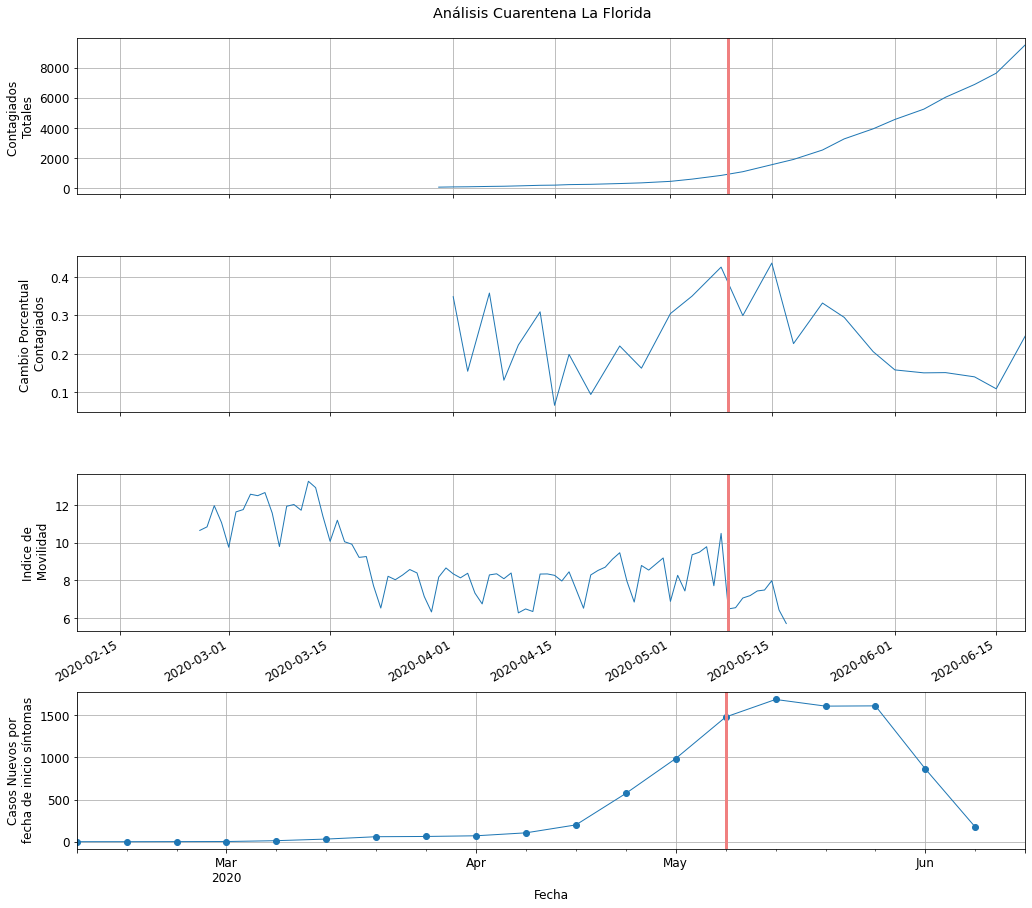

Cuarentenas La Florida:


,init_day,end_day
0,2020-05-09,2020-06-27


In [8]:
c_LF, q_LF, m_LF, s_LF = get_all(13110)
quarantine_analisis(c_LF, q_LF, m_LF, s_LF, "La Florida")
print("Cuarentenas La Florida:")
q_LF

    En el caso de la Florida se tiene que no se decretó cuarentena oficial sino hasta el 9 de Mayo. Aún así, la movilidad de la Florida disminuyó a partir de la quincena de Marzo, y se mantuvo así al menos hasta la quincena de Mayo (que es hasta donde llegan los datos). 
    Se puede observar también que el cambio porcentual fue aumentando con el paso de las semanas, y que solo empezó a disminuir una vez pasadas al menos la primera semana de cuarentena, por lo que se puede concluir que en esta comuna la cuarentena si fue efectiva y logró disminuir el número de casos. 
    
    Por último, analizamos el caso de Quilicura:
    

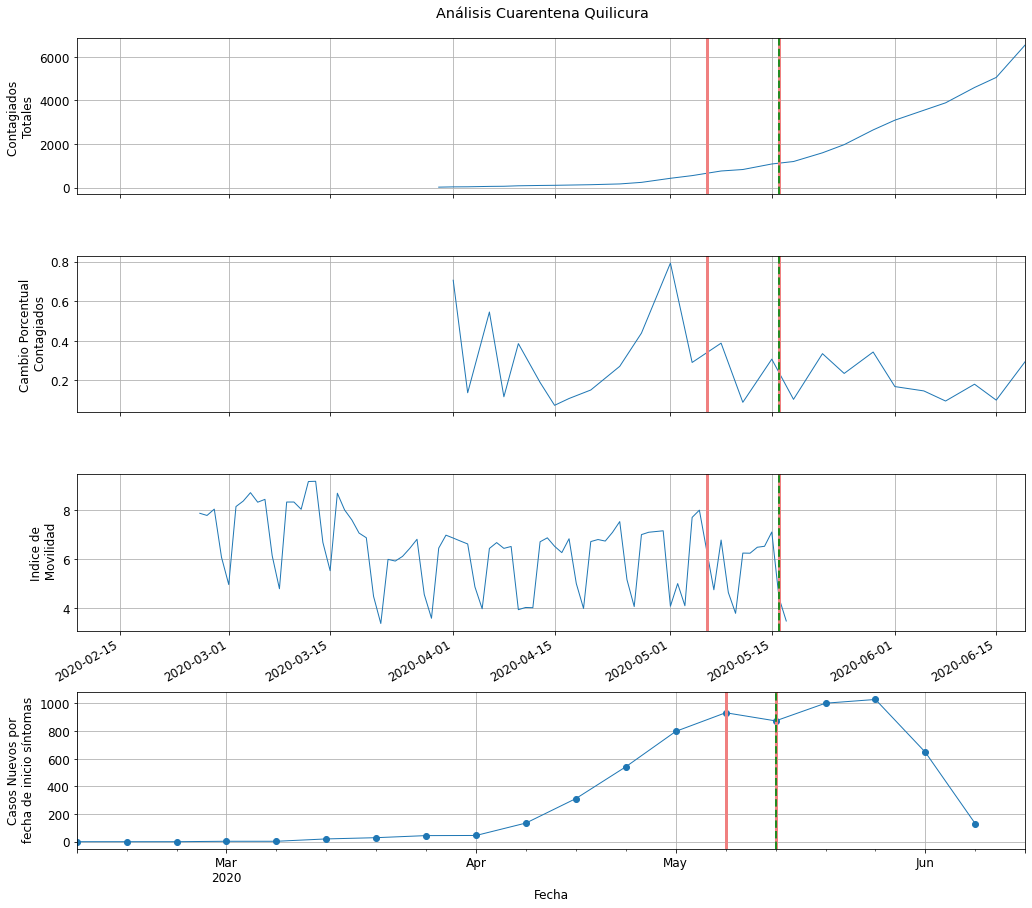

Cuarentenas Quilicura:


,init_day,end_day
0,2020-05-06,2020-05-16
1,2020-05-16,2020-06-27


In [9]:
c_QU, q_QU, m_QU, s_QU = get_all(13125)
quarantine_analisis(c_QU, q_QU, m_QU, s_QU, "Quilicura")
print("Cuarentenas Quilicura:")
q_QU

    En el caso de Quilicura, tampoco se declaró cuarentena sino hasta el 6 de Mayo, la cuals se extendió el día 16 de Mayo, como muestra la línea verde punteada sobre la roja. 
    En este caso notamos un comportamiento parecido al de Puente Alto con respecto a la movilidad, la cual no disminuye demasiado con el paso de los meses, ni siquiera cuando se decreta la cuarentena oficial para la comuna. 
    Por otro lado, de forma alarmante podemos notar que los primeros días de Mayo esta comuna llegó a un aumento porcentual del 0.8. Es decir que el número de contagiados prácticamente se duplicó con respecto al día anterior. Posterior a esto se decreta la cuarentena y podemos ver que en las semanas siguientes este peak no se supera y el crecimiento porcentual se mantiene por debajo del 0.4. También podemos observar que los casos nuevos por fecha de inicio de síntomas también comienzan a disminuir posterior a la cuarentena.
    Finalmente, al igual que en Puente Alto, también se podría concluir que si bien la movilidad no se vió muy afectada, la cuarentena si fue efectiva en disminuir los casos dos semanas después.

    En conclusión, podemos decir que si bien en algunas comunas como Puente Alto y Quilicura las cuarentenas no han logrado restringir la movilidad, si han sido efectivas en el sentido de que han logrado controlar el aumento porcentual del número de casos una vez que se han decretado. 